In [1]:
# Ejemplo de MCMC, donde se genera una secuencia basada en la verosimilitud
# Los datos sintéticos son generados con una distribución conocida (gamma) y luego
# se busca encontrar los parámetros

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

In [2]:
# Se generan los datos sintéticos con la distribución gamma
# Se consideran dos casos: pocos datos (N=100) y muchos (N=10000)
shape=6
scale=3.5
ndatos_corto=100
datos_corto = np.random.gamma(shape, scale, ndatos_corto)
ndatos_largo=10000
datos_largo = np.random.gamma(shape, scale, ndatos_largo)

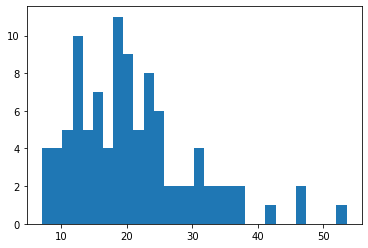

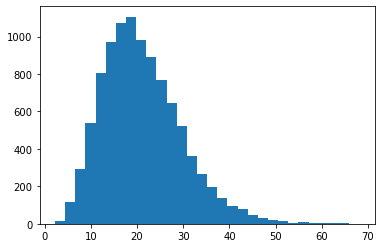

In [3]:
# Se grafican los histogramas de los datos, donde se ve que cuando son pocos,
# el histograma es muy ruidoso

plt.hist(datos_corto,30)
plt.show()
plt.hist(datos_largo,30)
plt.show()

In [4]:
# Se definen las rutinas necesarias para hacer el MCMC, usando el método de Metropolis

# Para la distribución gamma, la verosimilitud solo depende de n, sumdatos y sumlogdatos
# No es necesario pasar todos los datos, con lo que se hace más rápido el cáculo
# Para evitar números muy chicos o muy grandes, se calcula log_verosimilitud
# Los parámetros son a=(k,theta)
def log_verosimilitud(ndatos,sumadatos,sumalogdatos,k,theta):
    return -ndatos*k*np.log(theta)-ndatos*np.log(gamma(k))+(k-1)*sumalogdatos-sumadatos/theta

# Paso de Metropolis moviendo de manera continua k y theta
def paso_metropolis(ndatos,sumadatos,sumalogdatos,a):
    acandidato=np.zeros(2)
    acandidato[0]=a[0]+np.random.uniform(-0.1,0.1)
    acandidato[1]=a[1]+np.random.uniform(-0.2,0.2)
    if(acandidato[0]<=0):
        acandidato[0]=a[0]
    if(acandidato[1]<=0):
        acandidato[1]=a[1]        
    logr=(log_verosimilitud(ndatos,sumadatos,sumalogdatos,*acandidato)-
             log_verosimilitud(ndatos,sumadatos,sumalogdatos,*a))
    if np.log(np.random.uniform(0,1))<logr:
        return acandidato
    else:
        return a

# Paso de Metropolis moviendo de manera entera k y contiua theta
def paso_metropolis_int(ndatos,sumadatos,sumalogdatos,a):
    acandidato=np.zeros(2)
    acandidato[0]=a[0]+np.random.randint(-1,2)
    acandidato[1]=a[1]+np.random.uniform(-0.2,0.2)
    if(acandidato[0]<=0):
        acandidato[0]=a[0]
    if(acandidato[1]<=0):
        acandidato[1]=a[1]        
    logr=(log_verosimilitud(ndatos,sumadatos,sumalogdatos,*acandidato)-
             log_verosimilitud(ndatos,sumadatos,sumalogdatos,*a))
    if np.log(np.random.uniform(0,1))<logr:
        return acandidato
    else:
        return a
    
# Montecarlo completo, a partir de los datos primero calcula los cuantificadores claves
# que se usan en la verosimilitud
# Luego, se da una C.I. y se itera la termalización y luego la corrida larga
# Se retorna un arreglo Numpy con toda la secuencia MCMC
def MCMC(datos):
    ndatos=len(datos)
    sumadatos=np.sum(datos)
    sumalogdatos=np.sum(np.log(datos))

    #condicion incial
    a=[1,1]
    #pasos totales y termalizacion
    ntotal=5000000
    nterma=10000
    muestreoa=[]
    
    for i in range(nterma):
        a=paso_metropolis(ndatos,sumadatos,sumalogdatos,a)
    for i in range(ntotal):
        a=paso_metropolis(ndatos,sumadatos,sumalogdatos,a)
        muestreoa.append(a)
    muestreoa=np.array(muestreoa)
    return muestreoa

# Lo mismo, pero usando el Metropolis con pasos enteros en k
def MCMC_int(datos):
    ndatos=len(datos)
    sumadatos=np.sum(datos)
    sumalogdatos=np.sum(np.log(datos))

    #condicion incial
    a=[1,10]
    #pasos totales y termalizacion
    ntotal=300000
    nterma=10000
    muestreoa=[]
    
    for i in range(nterma):
        a=paso_metropolis_int(ndatos,sumadatos,sumalogdatos,a)
    for i in range(ntotal):
        a=paso_metropolis_int(ndatos,sumadatos,sumalogdatos,a)
        muestreoa.append(a)
    muestreoa=np.array(muestreoa)
    return muestreoa

In [39]:
# Análsis sencillo de los datos
# Calcula los promedios de los parámetros (podría ser mejor calcular la moda)
# Además, hace un histograma 2D y dos 1D
def analiza(seriea):
    print("Promedios:",np.mean(seriea,axis=0))
    plt.hist2d(seriea[:,0],seriea[:,1],100)
    plt.show()
    plt.hist(seriea[:,0],50)
    plt.show()
    plt.hist(seriea[:,1],50)
    plt.show()

In [40]:
# Se calcula una sencuecia MCMC usando el muestreo corto de la distribución gamma
# Ojo que la secuencia es de todos modos larga
a_corto=MCMC(datos_corto)

Promedios: [5.64721811 3.78428223]


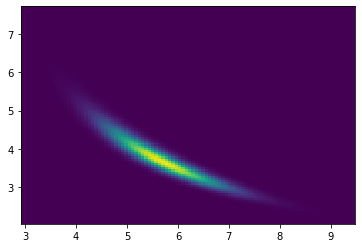

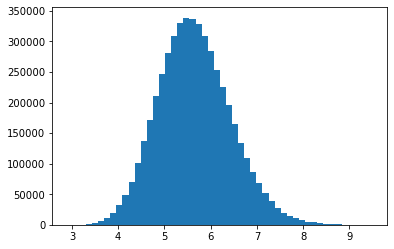

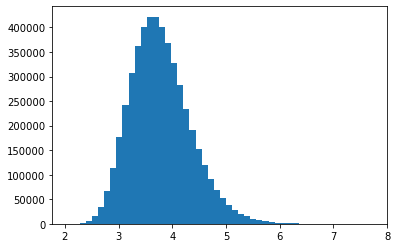

In [41]:
analiza(a_corto)

In [8]:
# Se calcula una sencuecia MCMC usando el muestreo largo de la distribución gamma
a_largo=MCMC(datos_largo)

Promedios: [6.06686166 3.48074609]


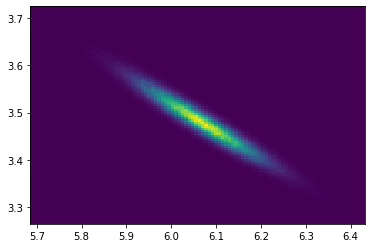

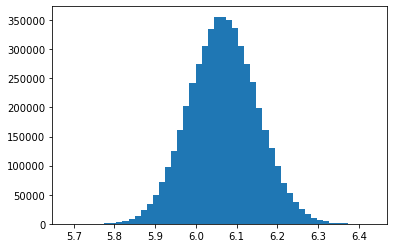

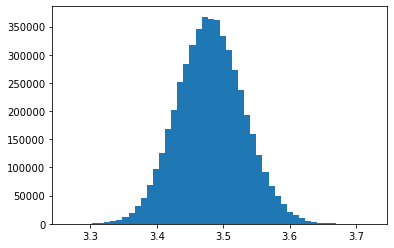

In [42]:
analiza(a_largo)

In [ ]:
# Lo mismo para los MCMC enteros
a_corto_int=MCMC_int(datos_corto)

In [ ]:
analiza(a_corto_int)

In [ ]:
a_largo_int=MCMC_int(datos_largo)

In [ ]:
analiza(a_largoo_int)

In [ ]:
# REGIONES DE CONFIANZA

In [33]:
# Dada una secuencia de Markov se grafica la región de confianza para un p dado
# Caso de dos parámetros: a=(a_0,a_1)
# Se puede dar parámetro graficatodo para que grafique cosas adicionales
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

def region_confianza(secuencia_a,p,graficatodo=False):
    # Primero se hace el histograma
    hist,xedges,yedges,image=plt.hist2d(secuencia_a[:,0],secuencia_a[:,1],400) #400 es el numero de bins
    if (graficatodo):
        plt.show()
    plt.clf() # Hay que hacer un clear o sino este plot se agrega al final

    # Se calcula la función hdep. Para eso, primero se hace la función pdeh
    # como la interpolación de las probs de que hist>=h
    rangoh=np.linspace(np.min(hist),np.max(hist),100)
    valorp=np.zeros(len(rangoh))
    for i in range(len(rangoh)):
        valorp[i]=(np.sum(hist[hist>=rangoh[i]])/np.sum(hist))
    if (graficatodo):
        plt.plot(rangoh,valorp)
        plt.grid()
        plt.show()
    pdeh = interp1d(rangoh,valorp)
    #hdep es la inversa de pdeh y se calcula con el método de la secante
    def hdep(p):
        def f(h):
            return pdeh(h)-p
        sol = root_scalar(f, x0=0, x1=np.max(hist), method='secant')
        return(sol.root)

    # Se hace una copia del histograma donde se pone a cero todos los valores menores
    # a hdep(p) y los mayores o iguales se ponen igual a p
    # Luego se grafica
    hist2=np.ma.masked_array(hist, hist < hdep(p))
    hist2[hist2 >= hdep(p)] = p # Si se quiere mantener el gradiente, se puede comentar
    X, Y = np.meshgrid(xedges, yedges)
    plt.pcolormesh(X, Y, hist2.T) # hay que trasponer
    plt.show()

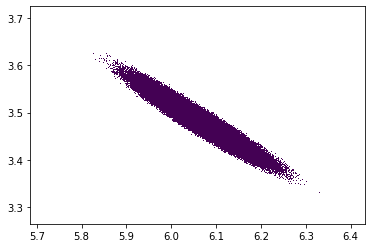

In [36]:
region_confianza(a_largo,0.95,graficatodo=False)

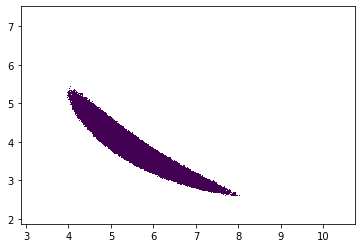

In [34]:
region_confianza(a_corto,0.95,graficatodo=False)

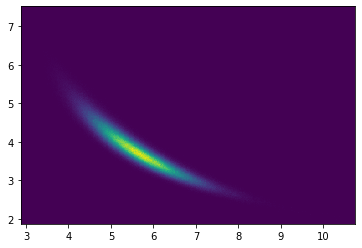

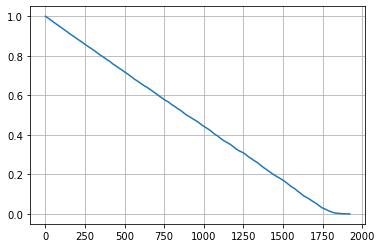

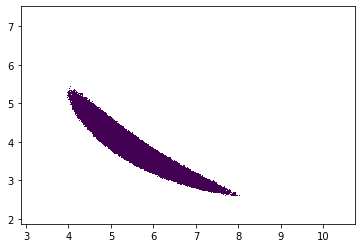

In [35]:
region_confianza(a_corto,0.95,graficatodo=True)

In [37]:
# Varias regiones de confianza
# El inicio es igual al otro modulo, con la diferencia que acepta una lista de valores
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

def regiones_confianza(secuencia_a,plist,graficatodo=False):
    # Primero se hace el histograma
    hist,xedges,yedges,image=plt.hist2d(secuencia_a[:,0],secuencia_a[:,1],400) #400 es el numero de bins
    if (graficatodo):
        plt.show()
    plt.clf() # Hay que hacer un clear o sino este plot se agrega al final

    # Se calcula la función hdep. Para eso, primero se hace la función pdeh
    # como la interpolación de las probs de que hist>=h
    rangoh=np.linspace(np.min(hist),np.max(hist),100)
    valorp=np.zeros(len(rangoh))
    for i in range(len(rangoh)):
        valorp[i]=(np.sum(hist[hist>=rangoh[i]])/np.sum(hist))
    if (graficatodo):
        plt.plot(rangoh,valorp)
        plt.grid()
        plt.show()
    pdeh = interp1d(rangoh,valorp)
    #hdep es la inversa de pdeh y se calcula con el método de la secante
    def hdep(p):
        def f(h):
            return pdeh(h)-p
        sol = root_scalar(f, x0=0, x1=np.max(hist), method='secant')
        return(sol.root)

    # Acá es lo nuevo
    plist=np.sort(plist)[::-1] # ordena en descendente
    hist2=np.copy(hist)
    hist2[hist2 <hdep(plist[0])] = 0
    for i in range(len(plist)-1):
        hist2[(hist2>=hdep(plist[i])) &(hist2 <hdep(plist[i+1]))] = hdep(plist[i])
    hist2[hist2 >=hdep(plist[-1])] = hdep(plist[-1])

    X, Y = np.meshgrid(xedges, yedges)
    plt.pcolormesh(X, Y, hist2.T)
    plt.show()

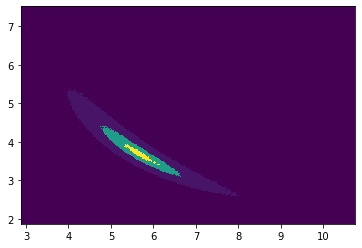

In [38]:
regiones_confianza(a_corto,[0.1,0.5,0.95])

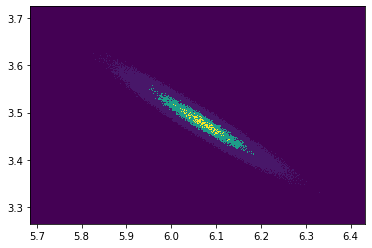

In [43]:
regiones_confianza(a_largo,[0.1,0.5,0.95])